In [1]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from torch.nn import Linear, LeakyReLU
from torch_geometric.nn import GCNConv

from sklearn.manifold import TSNE

In [2]:
fig_size = (4, 4)

In [3]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.xticks([])
    plt.yticks([])
    plt.scatter(h[:, 0], h[:, 1], s=10, c=color)
    
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
        
    plt.show()
    
def compute_accuracy(pred_y, y, mask):
    return (pred_y[mask] == y[mask]).sum() / mask.sum()

# Loading dataset

In [4]:
data_dir = 'datasets'

In [5]:
dataset = Planetoid(root=data_dir, name='Cora')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


## Basic statistics

Gather bisic statistics about the graph.

In [6]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

G = to_networkx(data, to_undirected=True)
print(f'Is connected: {nx.is_connected(G)}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Is connected: False


## Ploting 

Plot ego plots for random selected nodes. 

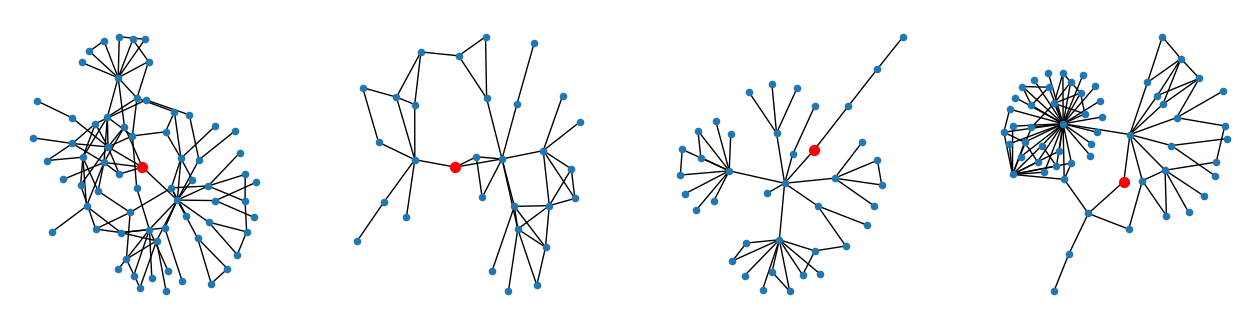

In [19]:
n_random = 4
fig, axis = plt.subplots(figsize=(4 * n_random, 4), nrows=1, ncols=n_random)

for i in range(n_random):
    random_node = np.random.choice(G.nodes())
    S = nx.ego_graph(G, n=random_node, radius=3)
    pos = nx.kamada_kawai_layout(S)
    nx.draw(S, node_size=20, pos=pos, ax=axis[i])
    nx.draw_networkx_nodes(S, pos=pos, nodelist=[random_node], node_size=50, node_color='red', ax=axis[i]);

# Implementing Graph Neural Networks

## Build model

Model: Semi-Supervised Classification with Graph Convolutional Networks  
https://arxiv.org/abs/1609.02907

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)
        
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        
        self.classifier = Linear(emb_dim, num_classes)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = torch.nn.functional.relu(h)
        h = torch.nn.functional.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        
        # Final layer of linear classifier
        out = self.classifier(h)
        
        # Return ca
        return h, out
    
model = GCN(num_features=dataset.num_features, hidden_dim=64, emb_dim=64, num_classes=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
)


## Check random embeddings

Let us examine the node embeddings generated by our GNN.

Embedding shape: [2708, 64]


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


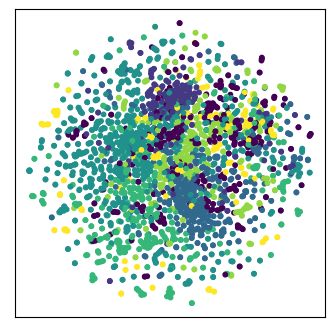

In [9]:
h, out = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

fig = plt.figure(figsize=fig_size)

tsne = TSNE()
trans_h = tsne.fit_transform(h.detach().numpy())
visualize_embedding(trans_h, color=data.y);

## Training on Cora

In [10]:
# Set up loss function and optimizer
lr = 0.0001
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-3)  # Define optimizer.

Training loop

In [11]:
n_epoch = 1000
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epoch):
    optimizer.zero_grad()
    h, out = model(data.x, data.edge_index)
    
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_accuracy = compute_accuracy(out.argmax(dim=1), data.y, mask=data.train_mask)
    
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy)
    
    train_loss.backward()
    optimizer.step()
    
    test_loss = criterion(out[data.test_mask], data.y[data.test_mask])
    test_accuracy = compute_accuracy(out.argmax(dim=1), data.y, mask=data.test_mask)
        
    test_losses.append(test_loss.item())  
    test_accuracies.append(test_accuracy)
    
    
    if (epoch+1) % 100 == 0:
        print('Epoch: {} - train(loss:{:.4f},acc:{:.4f}) test(loss:{:.4f},acc:{:.4f})'
              .format(epoch+1, train_loss.item(), train_accuracy, test_loss.item(), test_accuracy))

print('Finished Training')

Epoch: 100 - train(loss:1.8071,acc:0.6500) test(loss:1.8767,acc:0.3710)
Epoch: 200 - train(loss:1.4478,acc:0.9214) test(loss:1.6823,acc:0.6570)
Epoch: 300 - train(loss:0.9286,acc:0.9571) test(loss:1.3456,acc:0.7640)
Epoch: 400 - train(loss:0.5517,acc:0.9786) test(loss:1.0691,acc:0.7820)
Epoch: 500 - train(loss:0.3252,acc:0.9929) test(loss:0.8960,acc:0.7900)
Epoch: 600 - train(loss:0.2280,acc:0.9929) test(loss:0.8165,acc:0.7920)
Epoch: 700 - train(loss:0.1766,acc:1.0000) test(loss:0.7859,acc:0.7870)
Epoch: 800 - train(loss:0.1319,acc:0.9929) test(loss:0.7365,acc:0.7970)
Epoch: 900 - train(loss:0.1186,acc:0.9929) test(loss:0.7112,acc:0.7980)
Epoch: 1000 - train(loss:0.0938,acc:1.0000) test(loss:0.6934,acc:0.8020)
Finished Training


## Check embbeddings after training

Embedding shape: [2708, 64]


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


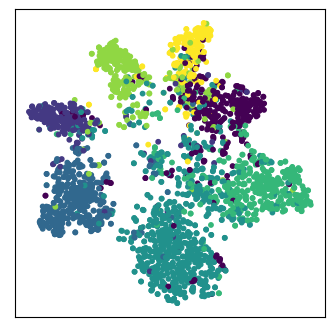

In [12]:
h, out = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

fig = plt.figure(figsize=fig_size)

tsne = TSNE()
trans_h = tsne.fit_transform(h.detach().numpy())
visualize_embedding(trans_h, color=data.y);

# Validate model

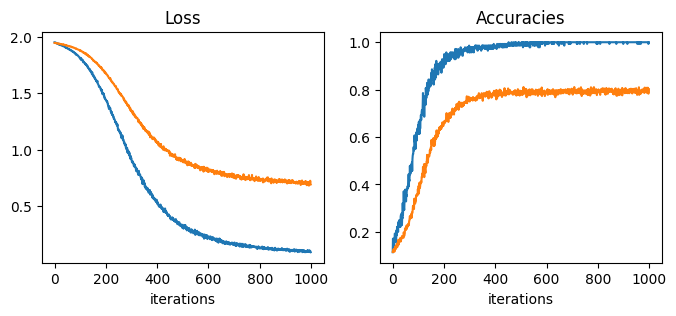

In [13]:
fig, axis = plt.subplots(figsize=(8, 3), nrows=1, ncols=2)

axis[0].plot(train_losses)
axis[0].plot(test_losses)

axis[0].set_title("Loss")
axis[0].set_xlabel("iterations")

axis[1].plot(train_accuracies)
axis[1].plot(test_accuracies)

axis[1].set_title("Accuracies")
axis[1].set_xlabel("iterations");

In [14]:
model.eval()
h, pred = model(data.x, data.edge_index)
train_acc = compute_accuracy(pred.argmax(dim=1), data.y, mask=data.train_mask)
test_acc = compute_accuracy(pred.argmax(dim=1), data.y, mask=data.test_mask)
print(f'Accuracy:\n- train {train_acc:.4f}\n- test  {test_acc:.4f}')

Accuracy:
- train 1.0000
- test  0.8120
